In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
time: 454 µs (started: 2023-11-05 00:42:42 +00:00)


# Vertex Cover Problem

Consider an undirected graph $G$ with vertices $V = \{ 1, \ldots, n \}$ and undirected edges $E$. Since the graph is undirected, we  consider edges $(i,j)$ and $(j,i)$ to be the _same_.

<div class="alert alert-block alert-info">
    <b> Vertex Cover: </b> A <i> vertex cover </i> of the graph is a subset $C \subseteq V$ such that every edge $e \in V$ has at least one of its end points in the set $C$.
    </div> 

Note that the entire vertex set $V$ is trivially a vertex cover. The vertex cover problem asks for the smallest size (cardinality) vertex cover for a given undirected graph $G$. 

<div class="alert alert-block alert-info">
 As a practical application, consider an advertiser who wishes to have advertisements on facebook or similar social media platform. They wish each person on the platform to see their ad but it is expensive to advertise to everyone. As it turns out, if they advertise to a person then all their friends on the platform get to see that ad as well in their timelines. Let's assume that everyone is friends with at least one other person. Thus, the company wishes to find the minimum set of people who are friends with everyone on the platform. One way to do it is to compute a vertex cover and advertise just to those people so that everyone is covered.
</div>

We have seen previously that the problem is NP-complete and can be solved in many ways including a reduction to integer linear programming. 

Here, we consider fast algorithms for computing an approximate vertex cover and our natural choice is to consider greedy algorithms.


## Example

<div class="alert alert-block" style="border-style: solid; border-width: 2px; border-color: white  white white green;" >
    
Consider the example below where we show a graph with five nodes and the nodes in the vertex cover shaded in orange. In fact, the set $\{ 1, 4, 5\}$ is a vertex cover but there is in fact a smaller vertex cover consisting just the nodes $\{4, 5\}$.

</div>

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
from pylab import rcParams

# Use matplotlib and networkx to plot graphs with a designated
# vertex cover passed in as a list of vertices.
# n: number of vertices
# edge_list: list of edges. please ensure that if edge (i,j) 
#            is present then (j,i) is not. We will not be checking this.
# vert_cover: list of vertices in the cover to highlight in orange.
# All nodes will be plotted in blue with vertex cover highlighted in orange.
def plot_graph_with_vc(n, edge_list, vert_cover):
    g = nx.Graph()
    g.add_edges_from(edge_list)
    pos = nx.spring_layout(g)  # positions for all nodes
    not_vert_cover = [i for i in range(1, n+1) if i not in vert_cover]
    plt.figure(1)
    nx.draw_networkx_nodes(g, pos, nodelist=vert_cover,  node_color="tab:orange")
    nx.draw_networkx_nodes(g, pos, nodelist=not_vert_cover,  node_color="tab:blue")
    nx.draw_networkx_edges(g, pos, edgelist=edge_list)
    nx.draw_networkx_labels(g, pos, font_size=12, font_color="whitesmoke")
    plt.show()
    

time: 699 ms (started: 2023-11-05 00:53:22 +00:00)


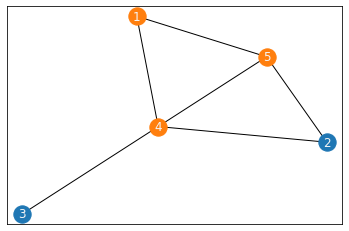

time: 329 ms (started: 2023-11-05 00:53:22 +00:00)


In [3]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
vert_cover = [1,  4, 5]
plot_graph_with_vc(5, edge_list, vert_cover)

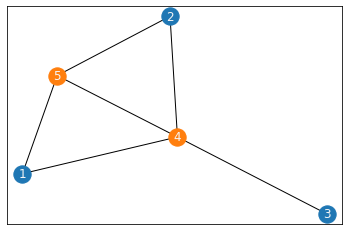

time: 284 ms (started: 2023-11-05 00:54:35 +00:00)


In [4]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
smaller_vert_cover = [4, 5]
plot_graph_with_vc(5, edge_list, smaller_vert_cover)

## Integer Linear Programming Formulation for Vertex Cover

We will present an integer linear programming formulation of the vertex cover problem. Let $G$ be a graph with vertices $V= \{ 1, \ldots, n \}$ and undirected edges $E$. The edges $(i,j)$ and $(j,i)$ are taken to be the same.

We will assume familiarity with the PuLP solver from previous lesson on linear programming.

### Decision Variables

We will have $n$ decision variables $w_1, \ldots, w_n$ that will be binary variables: they will have values in $\{0, 1\}$.  $w_i = 1$ indicates that the vertex $i$ is chosen as part of the cover and $w_i = 0$ tells us that it is not.

To declare a variable as binary in pulp, we simply use the following approach:
~~~
  wi = LpVariable('w_i', cat='Binary')
~~~

### Objective Function

With the decision variables fixed as above, the objective is simply

$$ \min w_1 + \cdots + w_n $$

We are minimizing the total over the binary variables which simply gives us the size of the cover.

### Constraints

The key constraints are that (a) $w_1,\ldots, w_n$ are binary (already mentioned above) and (b) for every edge $(i,j)$ at least one of $i,j$ must be in the cover. In other words, at least one of $w_i, w_j$ must be $1$. The inequalities take care of this requirement:

$$ w_i + w_j \geq 1,\ \text{for all edges}\ (i,j) \in E$$


### Putting it all together

The overall ILP is 

$$ \begin{array}{rl}
\max & \sum_{j=1}^n w_j \\ 
\mathsf{s.t.} & w_i + w_j \geq 1\ \text{for all edges}\ (i,j) \in E \\ 
& w_i \in \{ 0, 1\}\ \text{for all}\ i = 1, \ldots, n \\ 
\end{array}$$

In [7]:
from pulp import *


def compute_optimal_vertex_cover(n, edge_list):
    # Create a problem -- indicate that we will minimize the objectives
    prob = LpProblem('vert_cover', LpMinimize)
    # Add all the decision vars (we do this using comprehensions in Python but you could write a for-loop as well)
    dvars = [LpVariable(f'w_{i}', cat='Binary') for i in range(1, n+1)]
    # Note that lpSum is defined in Pulp and it simply takes the sum of all variables in a list of vars.
    prob += lpSum(dvars) # minimize the sum of the variables
    for (i, j) in edge_list: # go through each edge in the list
        assert 1 <= i <= n 
        assert 1 <= j <= n
        prob += dvars[i-1] + dvars[j-1] >= 1 # add the constraint -- wi + wj >= 1 -- indexing in python starts from 0 and thus we require the -1
    stat = prob.solve() # solve the problem
    assert stat == LpStatusOptimal, 'Problem does not have optimal status -- something went wrong -- this should not happen for this problem'
    vert_cover = [i+1 for i in range(n) if dvars[i].varValue > 0 ]
    return vert_cover

time: 1.79 ms (started: 2023-11-05 01:04:13 +00:00)


[4, 5]
Optimal vertex cover has 2 vertices: [4, 5]


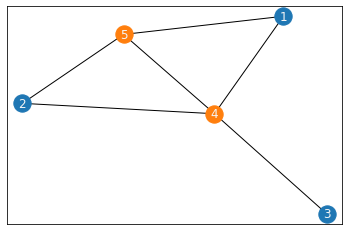

time: 456 ms (started: 2023-11-05 01:04:23 +00:00)


In [9]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
opt_vcover = compute_optimal_vertex_cover(5, edge_list)
print(opt_vcover)
print(f'Optimal vertex cover has {len(opt_vcover)} vertices: {opt_vcover}')
plot_graph_with_vc(5, edge_list, opt_vcover)

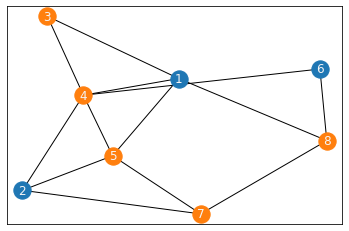

time: 503 ms (started: 2023-11-05 01:04:33 +00:00)


In [10]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5),(1,8),(2,7), (7,8),(4,6), (5,7), (6,8), (3,1)]
vcover = compute_optimal_vertex_cover(8, edge_list)
plot_graph_with_vc(8, edge_list, vcover)

Size of cover: 28 consisting of vertices [1, 2, 3, 5, 6, 8, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]


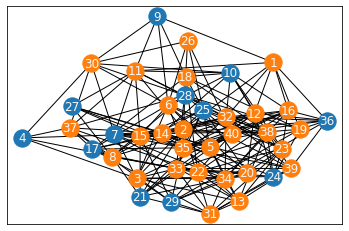

time: 613 ms (started: 2023-11-05 01:04:44 +00:00)


In [11]:
from random import randint
# graph with 40 vertices and 240 edges
n = 40
edge_list = [ ]
for _ in range(240):
    i = randint(1, n)
    j = randint(1, n)
    if i == 0 or j == 0 or i == j or (i,j) in edge_list or (j,i) in edge_list: 
        continue
    edge_list.append((i,j))

vcover = compute_optimal_vertex_cover(n, edge_list)
print(f'Size of cover: {len(vcover)} consisting of vertices {vcover}')
plot_graph_with_vc(n, edge_list, vcover)

## That's All Folks